# Two step task

The two step task is one of the most iconic tasks in RL (see Daw, ..., Dolan, Neuron 2011 for details). There are a lot of facets to it. Here, we will only focus on the behaviour of the model-free learner.

This code is based on the excellent paper from Thomas Akam, Rui Costa and Peter Dayan (PLOS Computational Biology, 2015): https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004648#sec002. This is a great ressource for learning many more things about the two-step task and possible ways to model it.

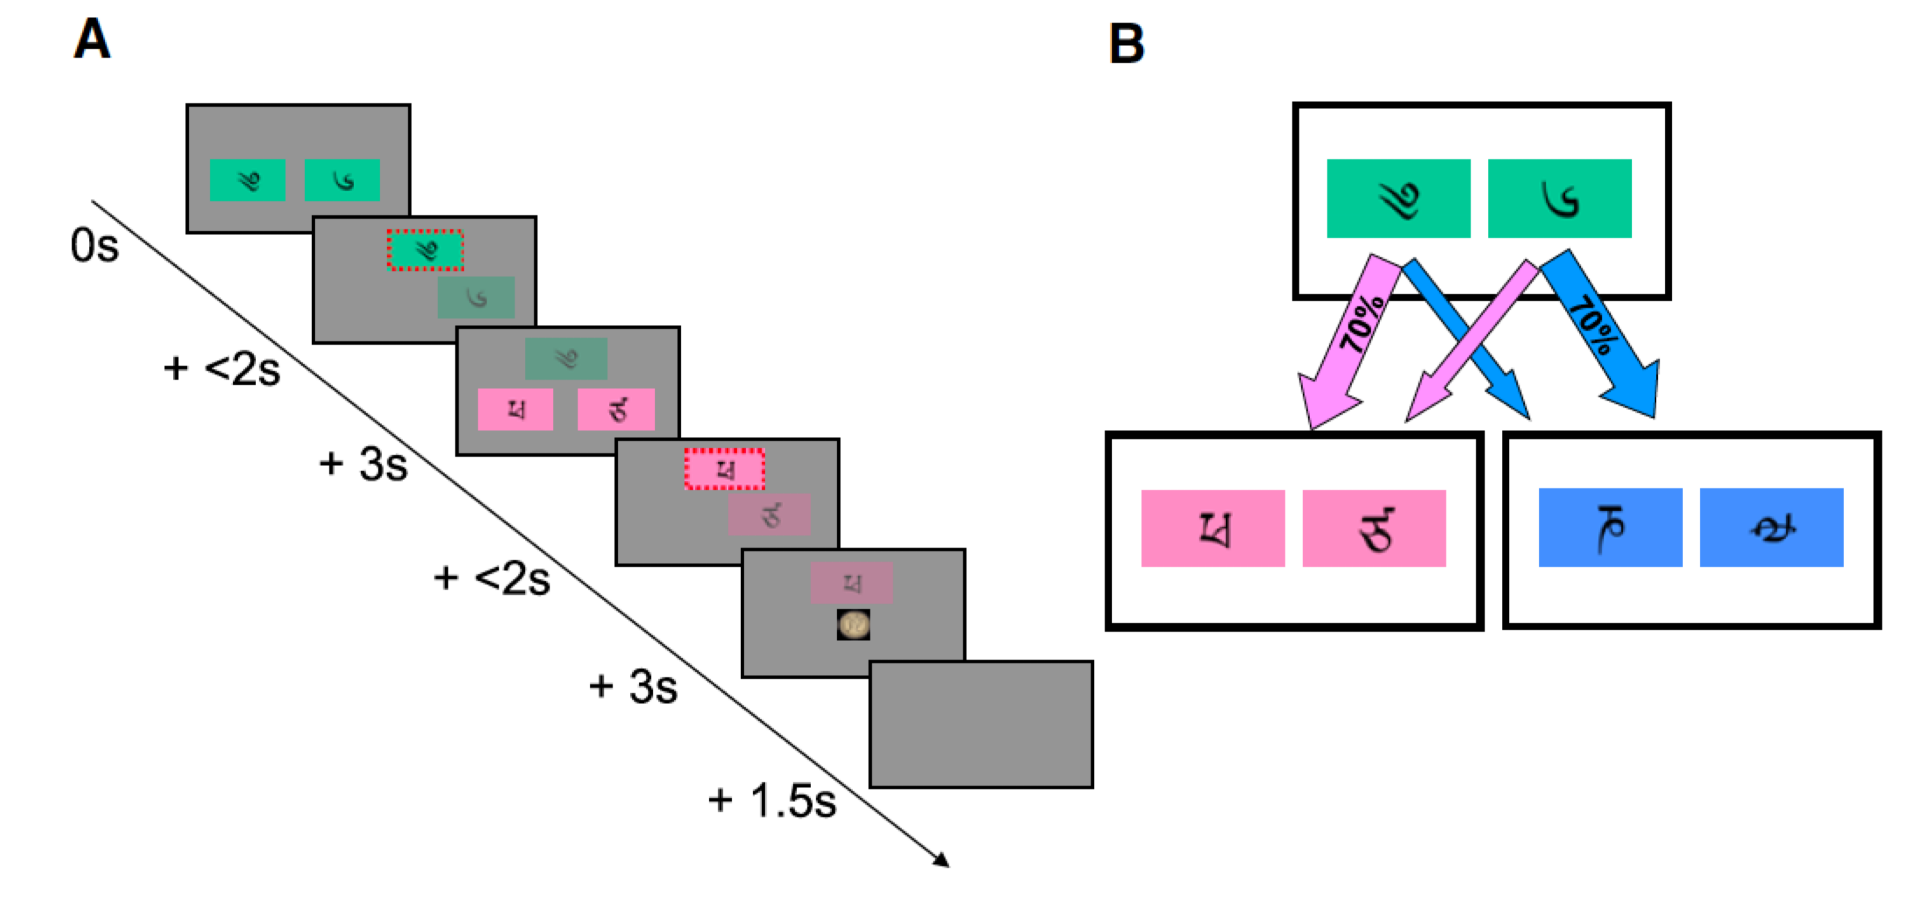

The key idea of the task is to have participants make decisions at **two time steps** (green: time step 1, pink/blue: time step 2). Every choice in the first (green) level will bring subjects to either the pink or blue level. Importantly: each of the two green first-level options as a **common** and **rare** **transition**, meaning that they usually lead to either pink or blue, but sometimes to the opposite colour.

When entering the second-level (pink or blue), subjects have to choose one of the available options and will receive a reward with a certain probability.

As we will see below, this task is interesting because it differentiates a **model-free** from a **model-based** learner. In essence, a model-free learner will simply repeat whatever has been rewarded in the past, whereas a model-based learner will incorporate the transition-probabilities (common vs. rare) to only repeat actions that will likely lead to reward.

We start with the usual imports and defining some helper functions.

In [1]:
# Imports
import numpy as np                 
import matplotlib.pyplot as plt
from random import random, randint
import sys

log_max_float = np.log(sys.float_info.max/2.1) # Log of largest possible floating point number.

In [2]:
# @title Helper functions

def choose(P):
  
  "Takes vector of probabilities P summing to 1, returns integer s with prob P[s]"

  return sum(np.cumsum(P) < random())

def softmax(Q,T):
  
  "Softmax choice probs given values Q and inverse temp T."

  QT = Q * T
  QT[QT > log_max_float] = log_max_float # Protection against overflow in exponential.    
  expQT = np.exp(QT)

  return expQT/expQT.sum()

def gauss_rand_walks(n_trials, step_SD, p_range = [0, 1], n_walks = 2):
  
  'Generate a set of reflecting Gaussian random walks.'
  
  walks = np.random.normal(scale = step_SD, size = (n_trials, n_walks))
  walks[0,:] = np.random.rand(n_walks)
  walks = np.cumsum(walks, 0)
  walks = np.mod(walks, 2.)
  walks[walks > 1.] = 2. - walks[walks > 1.]
  
  if p_range != [0, 1]:
      walks = walks  * (p_range[1]- p_range[0]) + p_range[0]
  
  return walks

def fixed_length_blocks(n_trials, probs, block_length):
  
  'Reversals in reward probabilities every block_length_trials.'
  
  block_1 = np.tile(probs,(block_length,1))
  block_2 = np.tile(probs[::-1],(block_length,1))
  
  return np.tile(np.vstack([block_1,block_2]), \
          (np.ceil(n_trials / (2. * block_length)),1,))[:n_trials,:]

def task_stats(n_trials = 1000,rew_gen = 'walks',step_SD = 0.025):
  
  'Generate a fresh set of reward probabilities.'

  if rew_gen == 'walks':   
      reward_probs  = gauss_rand_walks(n_trials, step_SD, p_range = [0.25, 0.75],
                                              n_walks = 4).reshape(n_trials,2,2)
  elif rew_gen == 'blocks':
      reward_probs = np.tile(fixed_length_blocks(n_trials, [0.2,0.8], 50 
                                  ).reshape(n_trials,2,1),[1,1,2])  
  rew_prob_iter = iter(reward_probs)

  return reward_probs, rew_prob_iter

def first_step(choice,com_prob = 0.7):
  'Given first step choice generate second step.'
  transition  = int(random() <  com_prob)   # 1 if common, 0 if rare.
  second_step = int(choice == transition)        # Choice 1 (0) commonly leads to second_step 1 (0).
  return second_step, transition

def second_step(second_step, choice_2,rew_prob_iter):
  outcome = int(random() < next(rew_prob_iter)[second_step, choice_2])
  return outcome

from scipy.stats import sem, ttest_rel

def setup_figure(fig_no = 1, clf = True):
  plt.figure(fig_no)
  if clf:plt.clf()

def stay_prob_plot(stay_probs, fig_no = 1, clf = True):
  'Plot stay probabilities with SEM errorbars for a list of sessions.'
  setup_figure(fig_no, clf)
  plt.bar(np.arange(1,5), np.mean(stay_probs,0), yerr = sem(stay_probs,0),
          error_kw = {'ecolor': 'r', 'capsize': 5, 'elinewidth': 5})
  plt.ylim(0,1)
  plt.xlim(0,5)
  plt.xticks([1,2,3,4],['Reward \n Common', 'Reward \n Rare', 'No Reward \n Common', 'No Reward \n Rare'])
  plt.ylabel('Stay Probability')

# Part 1: Define a model-free Q-Learner in the two-step task

Model-free learning here simply means that agents have a tendency to repeat whatever was rewarded previously. Let's see what this looks like:

In [3]:
def simulate_MF(n_trials = 1000, alpha=0.5, beta=5):

  # initialise variables:
  Q_td_1 = np.zeros(2)     # First step action values.
  Q_td_2 = np.zeros([2,2]) # Second step action values, indicies: [state, action]

  choices_1, second_steps, choices_2, rewards, transitions = (np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int))

  # initialise task statistics:
  reward_probs, rew_prob_iter = task_stats(n_trials)

  for i in range(n_trials):
    # Generate trial events.
    choice_1      = choose(softmax(Q_td_1, beta))      # First step action.
    next_state, t = first_step(choice_1)               # Find second step state.
    choice_2      = choose(softmax(Q_td_2[next_state,:], beta)) # Second_step action.
    reward        = second_step(next_state, choice_2, rew_prob_iter)            # Trial outcome.   

    # update action values
    Q_td_1[choice_1] = Q_td_1[choice_1] +  alpha * (reward - Q_td_1[choice_1])

    # Note that first-level and second-level actions are treated as independent - 
    # but you could also do:
    # Q_td_1[choice_1]     = Q_td_1[choice_1] +  alpha * (o + gamma*np.max(Q_td_2[s,:]) - Q_td_1[choice_1])
    # for some gamma, e.g. gamma=0.9

    Q_td_2[next_state,choice_2] = Q_td_2[next_state,choice_2] + alpha * (reward - Q_td_2[next_state,choice_2])

    choices_1[i], second_steps[i], choices_2[i], rewards[i], transitions[i]  = (choice_1, next_state, choice_2, reward, t)

  return choices_1, second_steps, choices_2, rewards, transitions

In [4]:
# @title Exercise 1.1: Algorithm and Parameters

Take a minute to go through the code and see if you can see what's going on. Do you remember what the parameters $\alpha$ and $\beta$ are doing?

Now let's have a look what the simulation looks like:

Behaviour MF agent:


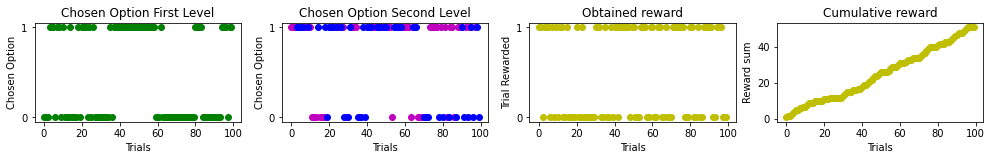

In [5]:
# @title Run to simulate behaviour
print("Behaviour MF agent:")

choices_1, second_steps, choices_2, rewards, _ = simulate_MF(n_trials = 100)

plt.rcParams['figure.figsize'] = [17, 4]
rows = 2
cols = 4
fig = plt.figure() 

fig_count = 1
fig.add_subplot(rows, cols, fig_count)
plt.plot(choices_1,'go')
plt.xlabel('Trials')
plt.ylabel('Chosen Option')
plt.yticks([0,1])
plt.title('Chosen Option First Level')

idx_2_0 = np.where(second_steps==0)[0]
idx_2_1 = np.where(second_steps==1)[0]
trls = np.arange(len(second_steps))

fig_count = 2
fig.add_subplot(rows, cols, fig_count)
plt.plot(trls[idx_2_0],choices_2[idx_2_0],'mo')
plt.plot(trls[idx_2_1],choices_2[idx_2_1],'bo')
plt.xlabel('Trials')
plt.ylabel('Chosen Option')
plt.yticks([0,1])
plt.title('Chosen Option Second Level')

fig_count = 3
fig.add_subplot(rows, cols, fig_count)
plt.plot(rewards,'yo')
plt.xlabel('Trials')
plt.ylabel('Trial Rewarded')
plt.yticks([0,1])
plt.title('Obtained reward')

fig_count = 4
fig.add_subplot(rows, cols, fig_count)
plt.plot(np.cumsum(rewards),'yo')
plt.xlabel('Trials')
plt.ylabel('Reward sum')
plt.title('Cumulative reward')

plt.show()

In [6]:
# @title Exercise 1.2: How does the above learning work?

# Part 2: Get 'Stay Probabilities'

We can now analyse the 'stay probabilities' for the first level choice and the model-free Q-learner. First, let's compute them:

In [7]:
def session_stay_probs(choices_1=[],transitions=[],rewards=[]):
  
  'Evaluate stay probabilities for a single session'

  if len(choices_1)==0:
    choices_1, _, _, rewards, transitions = simulate_MF(n_trials = 100)

  # stay = current first-level choice is same as in previous trial
  stay = choices_1[1:] == choices_1[:-1]

  stay_probs = np.zeros(4)

  idx_RewComm  = np.logical_and(transitions[:-1]==1, rewards[:-1]==1)
  idx_RewRare  = np.logical_and(transitions[:-1]==0, rewards[:-1]==1)
  idx_NRewComm = np.logical_and(transitions[:-1]==1, rewards[:-1]==0)
  idx_NRewRare = np.logical_and(transitions[:-1]==0, rewards[:-1]==0)

  stay_probs[0] = np.mean(stay[idx_RewComm]) # Rewarded, common transition.
  stay_probs[1] = np.mean(stay[idx_RewRare]) # Rewarded, rare transition.
  stay_probs[2] = np.mean(stay[idx_NRewComm]) # Non-rewarded, common transition.
  stay_probs[3] = np.mean(stay[idx_NRewRare]) # Non-rewarded, rare transition.

  return stay_probs

Session 0 of 10 done.
Session 1 of 10 done.
Session 2 of 10 done.
Session 3 of 10 done.
Session 4 of 10 done.
Session 5 of 10 done.
Session 6 of 10 done.
Session 7 of 10 done.
Session 8 of 10 done.
Session 9 of 10 done.


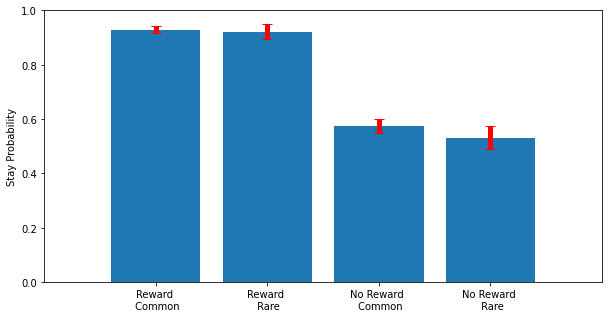

In [8]:
# @title Run to get stay probabilities
n_sessions = 10    # Number of sessions per agent.
n_trials   = 100  # Number of trials per session.

stay_probs = np.zeros((n_sessions,4))

for idx_sess in np.arange(n_sessions):
  choices_1, _, _, rewards, transitions = simulate_MF(n_trials)
  stay_probs[idx_sess,:] = session_stay_probs(choices_1,transitions,rewards)

  print("Session " + str(idx_sess) + " of " + str(n_sessions) + " done.")

plt.rcParams['figure.figsize'] = [10, 5]
stay_prob_plot(stay_probs) # this is a helper function to plot from above

In [9]:
# @title Exercise 2.1: What do we see?

# Part 3: Define a model-based Q-Learner in the two-step task

In contrast to a model-free learner, a model-based learner incorporates its knowledge about the transition statistics into its learning.

Has it been rewarded after a rare transition? It should then take the option that leads to the previously rewarded outcome with a **common transition**!

In [10]:
def simulate_MB(n_trials = 1000, alpha=0.5, beta=5):

  # initialise variables:
  transition = np.zeros(n_trials)

  Q_mb   = np.zeros(2)      # Model based action values - at first-level!

  Q_td_2 = np.zeros([2,2])  # Second_step action values, indicies: [state, action]

  choices_1, second_steps, choices_2, rewards, transitions = (np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int))

  # initialise task statistics:
  reward_probs, rew_prob_iter = task_stats(n_trials)

  for i in range(n_trials):
    # Generate trial events.
    choice_1      = choose(softmax(Q_mb, beta))   # First_step action (model-based)
    next_state, t = first_step(choice_1)          # Second step state.

    choice_2 = choose(softmax(Q_td_2[next_state,:], beta)) # Second_step action.
    reward   = second_step(next_state, choice_2, rew_prob_iter) # Trial outcome.  

    # Update action values.
    # At second time-step:
    Q_td_2[next_state,choice_2] = Q_td_2[next_state,choice_2] + alpha * (reward - Q_td_2[next_state,choice_2])

    # At first time-step:
    Q_s  = np.max(Q_td_2, 1) # State values are max action value available in each state.
    Q_mb = 0.7 * Q_s + 0.3 * Q_s[::-1]

    choices_1[i], second_steps[i], choices_2[i], rewards[i], transitions[i]  = (choice_1, next_state, choice_2, reward, t)

  return choices_1, second_steps, choices_2, rewards, transitions

Behaviour MB agent:


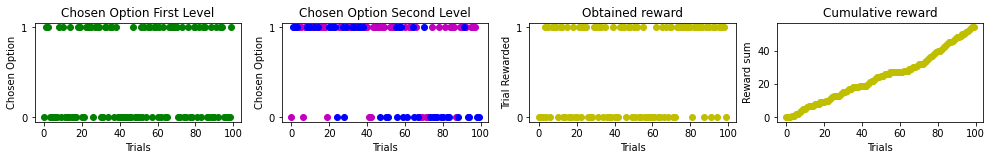

In [11]:
# @title Run to simulate behaviour
print("Behaviour MB agent:")

choices_1, second_steps, choices_2, rewards, _ = simulate_MB(n_trials = 100)

plt.rcParams['figure.figsize'] = [17, 4]
rows = 2
cols = 4
fig = plt.figure() 

fig_count = 1
fig.add_subplot(rows, cols, fig_count)
plt.plot(choices_1,'go')
plt.xlabel('Trials')
plt.ylabel('Chosen Option')
plt.yticks([0,1])
plt.title('Chosen Option First Level')

idx_2_0 = np.where(second_steps==0)[0]
idx_2_1 = np.where(second_steps==1)[0]
trls = np.arange(len(second_steps))

fig_count = 2
fig.add_subplot(rows, cols, fig_count)
plt.plot(trls[idx_2_0],choices_2[idx_2_0],'mo')
plt.plot(trls[idx_2_1],choices_2[idx_2_1],'bo')
plt.xlabel('Trials')
plt.ylabel('Chosen Option')
plt.yticks([0,1])
plt.title('Chosen Option Second Level')

fig_count = 3
fig.add_subplot(rows, cols, fig_count)
plt.plot(rewards,'yo')
plt.xlabel('Trials')
plt.ylabel('Trial Rewarded')
plt.yticks([0,1])
plt.title('Obtained reward')

fig_count = 4
fig.add_subplot(rows, cols, fig_count)
plt.plot(np.cumsum(rewards),'yo')
plt.xlabel('Trials')
plt.ylabel('Reward sum')
plt.title('Cumulative reward')

plt.show()

Session 0 of 10 done.
Session 1 of 10 done.
Session 2 of 10 done.
Session 3 of 10 done.
Session 4 of 10 done.
Session 5 of 10 done.
Session 6 of 10 done.
Session 7 of 10 done.
Session 8 of 10 done.
Session 9 of 10 done.


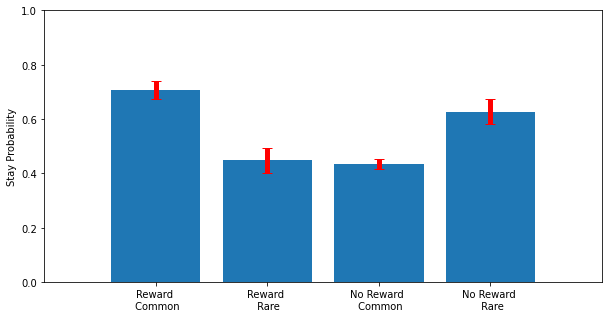

In [12]:
# @title Run to get stay probabilities
n_sessions = 10     # Number of sessions per agent.
n_trials   = 100  # Number of trials per session.

stay_probs = np.zeros((n_sessions,4))

for idx_sess in np.arange(n_sessions):
  choices_1, second_steps, choices_2, rewards, transitions = simulate_MB(n_trials)
  stay_probs[idx_sess,:] = session_stay_probs(choices_1,transitions,rewards)

  print("Session " + str(idx_sess) + " of " + str(n_sessions) + " done.")

plt.rcParams['figure.figsize'] = [10, 5]
stay_prob_plot(stay_probs) # this is a helper function to plot from above

In [13]:
# @title Exercise 3.1: What do we see?

The above plot reproduces the model-based action probabilities from the main paper. Can you tell what's the key difference in the simulate_MB code that produces 'model-based' Q-values?

Can you see a performance difference between a model-free and model-based agent?

# Part 4: Model-free and model-based learning in the two-step task

Studies tend to find that empirical behaviour is a mix of model-free and model based behaviour. The following function defines one way of achieving this mix via a **weighting** between a MF and MB controller:

In [14]:
def simulate_MFMB(n_trials = 1000, alpha=0.5, beta=5, w=0.5):

  Q_mb   = np.zeros(2)      # Model-based (first-step) action values
  Q_td_1 = np.zeros(2)      # First step action values

  Q_td_2 = np.zeros([2,2])  # Second_step action values, indicies: [state, action]

  choices_1, second_steps, choices_2, rewards, transitions = (np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int))

  # initialise task statistics:
  reward_probs, rew_prob_iter = task_stats(n_trials)

  for i in range(n_trials):
    # Generate trial events.
    # weighted_Q = np.multiply(Q_mb,w) + np.multiply(Q_td_1,1-w)
    weighted_Q = w * Q_mb + (1-w) * Q_td_1

    choice_1      = choose(softmax(weighted_Q, beta)) # First_step action.
    next_state, t = first_step(choice_1)              # Second step state.

    choice_2 = choose(softmax(Q_td_2[next_state,:], beta)) # Second_step action.
    reward   = second_step(next_state, choice_2, rew_prob_iter) # Trial outcome.  

    # update action values.
    # At first time-step (model-free):
    Q_td_1[choice_1] = Q_td_1[choice_1] +  alpha * (reward - Q_td_1[choice_1])

    # At first time-step (model-based):
    Q_s = np.max(Q_td_2, 1) # State values are max action value available in each state.
    Q_mb   = 0.7 * Q_s + 0.3 * Q_s[::-1]    

    # At second time-step:
    Q_td_2[next_state,choice_2] = Q_td_2[next_state,choice_2] + alpha * (reward - Q_td_2[next_state,choice_2])

    choices_1[i], second_steps[i], choices_2[i], rewards[i], transitions[i]  = (choice_1, next_state, choice_2, reward, t)

  return choices_1, second_steps, choices_2, rewards, transitions

Behaviour MF + MB agent:


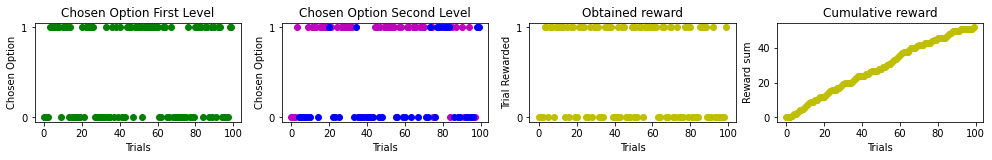

In [15]:
# @title Run to simulate behaviour
print("Behaviour MF + MB agent:")

choices_1, second_steps, choices_2, rewards, _ = simulate_MFMB(n_trials = 100)

plt.rcParams['figure.figsize'] = [17, 4]
rows = 2
cols = 4
fig = plt.figure() 

fig_count = 1
fig.add_subplot(rows, cols, fig_count)
plt.plot(choices_1,'go')
plt.xlabel('Trials')
plt.ylabel('Chosen Option')
plt.yticks([0,1])
plt.title('Chosen Option First Level')

idx_2_0 = np.where(second_steps==0)[0]
idx_2_1 = np.where(second_steps==1)[0]
trls = np.arange(len(second_steps))

fig_count = 2
fig.add_subplot(rows, cols, fig_count)
plt.plot(trls[idx_2_0],choices_2[idx_2_0],'mo')
plt.plot(trls[idx_2_1],choices_2[idx_2_1],'bo')
plt.xlabel('Trials')
plt.ylabel('Chosen Option')
plt.yticks([0,1])
plt.title('Chosen Option Second Level')

fig_count = 3
fig.add_subplot(rows, cols, fig_count)
plt.plot(rewards,'yo')
plt.xlabel('Trials')
plt.ylabel('Trial Rewarded')
plt.yticks([0,1])
plt.title('Obtained reward')

fig_count = 4
fig.add_subplot(rows, cols, fig_count)
plt.plot(np.cumsum(rewards),'yo')
plt.xlabel('Trials')
plt.ylabel('Reward sum')
plt.title('Cumulative reward')

plt.show()

Session 0 of 10 done.
Session 1 of 10 done.
Session 2 of 10 done.
Session 3 of 10 done.
Session 4 of 10 done.
Session 5 of 10 done.
Session 6 of 10 done.
Session 7 of 10 done.
Session 8 of 10 done.
Session 9 of 10 done.


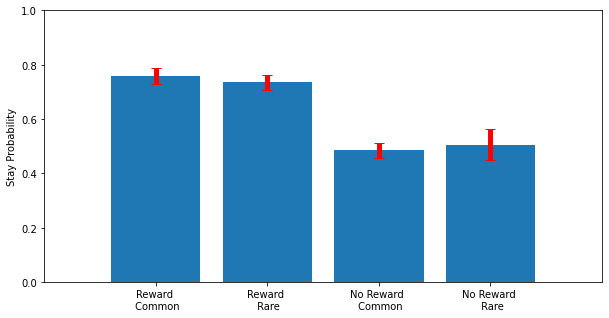

In [16]:
# @title Run to get stay probabilities
n_sessions = 10   # Number of sessions per agent.
n_trials   = 100  # Number of trials per session.

stay_probs = np.zeros((n_sessions,4))

for idx_sess in np.arange(n_sessions):
  choices_1, _, choices_2, rewards, transitions = simulate_MFMB(n_trials)
  stay_probs[idx_sess,:] = session_stay_probs(choices_1,transitions,rewards)

  print("Session " + str(idx_sess) + " of " + str(n_sessions) + " done.")

plt.rcParams['figure.figsize'] = [10, 5]
stay_prob_plot(stay_probs) # this is a helper function to plot from above

In [17]:
# @title Exercise 4.1: Model-based and model-free control

The above replicates the empirical results found in the original (and many following) paper(s). Can you figure out what happens in the simulate_MFMB code, and which parameter governs the trade-off between model-free and model-based behaviour? What happens if that parameter takes more extreme values (e.g. 0 or 1)? 

# Part 5: Model Fitting

Model-fitting could fill an entire seminar. The basic idea is simple though: find model parameters that produce simulated behaviour that most closely approximates observed behaviour.

The basic idea is to find a set of parameters that maximises a likelihood function (the below equations definitions are grossly simplified):

$$argmax_{\theta \in \Theta}\mathcal{L}_n(\theta,Y)$$

Where $\theta$ is a set of parameters and $Y=(y_1,...,y_n)$ is a set of observations.

We can take some simplifying assumptions, such as taking the $log$ of the above and treating the likelihood as the summed likelihood of all individual data points:

$$argmax_{\theta \in \Theta} \sum_i \log \mathcal{L}(\theta,y_i)$$

And because we only have binary choice data, we can make it very simple: let's find parameters that maximise the log-probability of every choice:

$$argmax_{\theta \in \Theta} \sum_i \log P(choice_i|\theta)$$

In the following, we will see this process in action, without being able to go through the details.

## 5.1 Model-free agent

Let's see what this looks like in our model-free agent. Which parameters do you think can we estimate here?

In [18]:
# @title More helper functions

import math

def array_softmax(Q,T):

  '''Array based calculation of softmax probabilities for binary choices.
  Q: Action values - array([n_trials,2])
  T: Inverse temp  - float.'''
  P = np.zeros(Q.shape)

  TdQ = -T*(Q[:,0]-Q[:,1])

  TdQ[TdQ > log_max_float] = log_max_float # Protection against overflow in exponential.  

  P[:,0] = 1./(1. + np.exp(TdQ))

  P[:,1] = 1. - P[:,0]
  
  return P

def protected_log(x):

  'Return log of x protected against giving -inf for very small values of x.'
  
  return np.log(((1e-200)/2)+(1-(1e-200))*x)

def trans_UC(values_U, param_ranges):
  
  'Transform parameters from unconstrained to constrained space.'

  values_T = []

  for value, rng in zip(values_U, param_ranges):
      if rng   == 'unit':  # Range: 0 - 1.
          if value < -16.:
              value = -16.
          values_T.append(1./(1. + math.exp(-value)))  # Don't allow values smaller than 1e-
      elif rng == 'pos':  # Range: 0 - inf
          if value > 16.:
              value = 16.
          values_T.append(math.exp(value))  # Don't allow values bigger than ~ 1e7.
          
  return np.array(values_T)

def trans_CU(values_T, param_ranges):
    
  'Transform parameters from constrained to unconstrained space.'
  values_U = []

  for value, rng in zip(values_T, param_ranges):
      if rng   == 'unit':
          values_U.append(-math.log((1./value)-1))
      elif rng == 'pos':
          values_U.append(math.log(value))

  return np.array(values_U)

def plot_fit(choices_1,choices_2,choice_probs_f,choice_probs_s):

  n_trials = len(choices_1)

  choice_probs_f_chosen = np.zeros(n_trials)
  choice_sim_f = np.zeros(n_trials)

  choice_probs_s_chosen = np.zeros(n_trials)
  choice_sim_s = np.zeros(n_trials)

  for idx_trl in np.arange(n_trials):
    choice_probs_f_chosen[idx_trl] = choice_probs_f[idx_trl,choices_1[idx_trl]]

    choice_sim_f[idx_trl] = np.argmax(choice_probs_f[idx_trl,:])

    choice_probs_s_chosen[idx_trl] = choice_probs_s[idx_trl,choices_2[idx_trl]]

    choice_sim_s[idx_trl] = np.argmax(choice_probs_s[idx_trl,:])

  plt.rcParams['figure.figsize'] = [15, 10]
  rows = 2
  cols = 2
  fig = plt.figure() 

  fig_count = 1
  fig.add_subplot(rows, cols, fig_count)
  plt.plot(choices_1,label="Observed Choices")
  plt.plot(choice_sim_f,'o',label="Estimated Choices")
  plt.xlabel('Trials')
  plt.ylabel('Chosen Option')
  plt.yticks([0,1])
  plt.legend()
  plt.title('Chosen/Estimated Option First Level')

  fig_count = 2
  fig.add_subplot(rows, cols, fig_count)
  plt.plot(choice_probs_f_chosen,'--k')
  plt.xlabel('Trials')
  plt.ylabel('Probability')
  plt.yticks([0,1])
  plt.title('Probability Observed Choice by Model First Level')

  fig_count = 3
  fig.add_subplot(rows, cols, fig_count)
  plt.plot(choices_2,label="Observed Choices")
  plt.plot(choice_sim_s,'o',label="Estimated Choices")
  plt.xlabel('Trials')
  plt.ylabel('Chosen Option')
  plt.yticks([0,1])
  plt.legend()
  plt.title('Chosen/Estimated Option Second Level')

  fig_count = 4
  fig.add_subplot(rows, cols, fig_count)
  plt.plot(choice_probs_s_chosen,'--k')
  plt.xlabel('Trials')
  plt.ylabel('Chosen Option')
  plt.yticks([0,1])
  plt.title('Probability Observed Choice by Model Second Level')

  plt.show()

import scipy.optimize as op

def fit_session(likelihood_func, param_ranges, params, param_names,
                choices_1, second_steps, choices_2, reward,
                repeats = 5, brute_init = True, verbose = False):
  '''Find maximum likelihood parameter estimates for a session or list of sessions. '''

  method = 'Nelder-Mead'
  calculates_gradient = False
  fit_func   = lambda params: -likelihood_func(trans_UC(params, param_ranges), choices_1, second_steps, choices_2, reward)

  n_params = len(params)

  fits = []
  for i in range(repeats): # Perform fitting.
    
    # Initialise minimisation with brute force search.
    ranges = tuple([(-5,5) for i in range(n_params)])
    
    init_params = op.brute(fit_func, ranges, Ns =  20, 
                          full_output = True, finish = None)[0]

    fits.append(op.minimize(fit_func, init_params, jac = calculates_gradient,
                                method = method, options = {'disp': verbose}))
    
    print("Finished simulation " + str(i+1) + " of " + str(repeats) + ".")
    
  fit = fits[np.argmin([f['fun'] for f in fits])]  # Select best fit out of repeats.

  session_fit = {'likelihood' : - fit['fun'],
                  'param_names': param_names} 

  session_fit['params'] = trans_UC(fit['x'], param_ranges)

  print(session_fit)

  return session_fit

The following function defines a way to obtain the likelihood for a model-free agent. This is very dense - but maybe you can guess what some of the parts are doing?

In [19]:
def session_likelihood_MF(params, choice_1=[], second_steps=[], choice_2=[], reward=[], fit=True):

  # Unpack parameters - this is the key idea
  alpha, beta = params  

  # Unpack trial events.
  if len(choice_1)==0:
    n_trials   = 100  # Number of trials per session.
    choice_1, second_steps, choice_2, reward, _ = simulate_MF(n_trials)
  else:
    n_trials = len(choice_1)

  # Initiate variables
  Q_td_1 = np.zeros(2)     # First step action values.
  Q_td_2 = np.zeros([2,2]) # Second step action values, indicies: [state, action]

  Q_td_1_array = np.zeros([n_trials + 1, 2])     # First step action values.
  Q_td_2_array = np.zeros([n_trials + 1, 2])     # Second step action values for second step reached on each trial.

  # simulate updating of Q-values based on REAL experience given as input
  for i in range(n_trials):

    for j in range(2):
      Q_td_1_array[i,j] = Q_td_1[j]
      Q_td_2_array[i,j] = Q_td_2[second_steps[i],j]

    # update action values
    Q_td_1[choice_1[i]] = Q_td_1[choice_1[i]] +  alpha * (reward[i] - Q_td_1[choice_1[i]])

    Q_td_2[second_steps[i],choice_2[i]] = Q_td_2[second_steps[i],choice_2[i]] + alpha * (reward[i] - Q_td_2[second_steps[i],choice_2[i]])

  # Evaluate choice probabilities and likelihood.
  choice_probs_1 = array_softmax(Q_td_1_array, beta)
  choice_probs_2 = array_softmax(Q_td_2_array, beta)

  # Now find the log-likelihood of every choice - this is the other key idea
  trial_log_likelihood_1 = protected_log(choice_probs_1[np.arange(n_trials), choice_1])
  trial_log_likelihood_2 = protected_log(choice_probs_2[np.arange(n_trials), choice_2])

  session_log_likelihood = np.sum(trial_log_likelihood_1) + np.sum(trial_log_likelihood_2) 
  
  if fit:
    return session_log_likelihood
  else:
    return session_log_likelihood, choice_probs_1, choice_probs_2

Based on our likelihood-definition above, we can now get the likelihood for certain parameter values.

The function fit_session will use this to find the parameter values that maximisies the likelihood. Let's see what this looks like:

Finished simulation 1 of 5.
Finished simulation 2 of 5.
Finished simulation 3 of 5.
Finished simulation 4 of 5.
Finished simulation 5 of 5.
{'likelihood': -88.6216425241391, 'param_names': ['alpha', 'beta'], 'params': array([0.57615641, 4.00584601])}


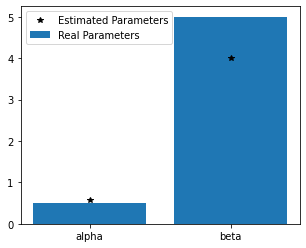

Compare true and fitted values:


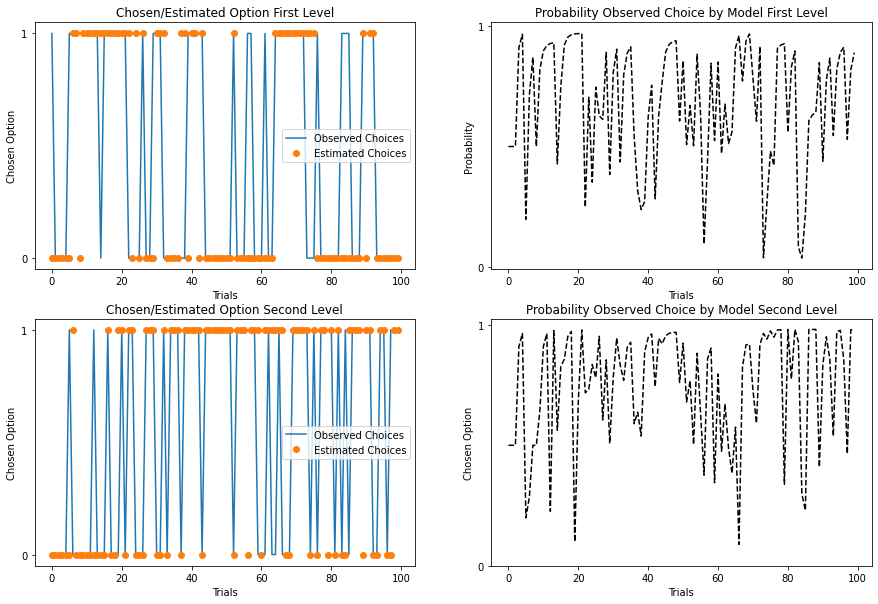

In [20]:
likelihood_func = session_likelihood_MF
param_ranges    = ['unit','pos'] # don't worry about this
param_names     = ["alpha","beta"] # parameters we want to estimate
params          = [0.5, 5] # initial parameter values

# Let's simulate some data under some true parameter values:
# You can think of this as the real behaviour that we obtain from a participant
choices_1, second_steps, choices_2, reward, _ = simulate_MF(n_trials = 100, alpha=params[0], beta=params[1])

# Let's use our likelihood-function above to find parameter estimates that approximate the simulated behaviour above
session_fit = fit_session(likelihood_func, param_ranges, params, param_names,
                          choices_1, second_steps, choices_2, reward,
                          repeats = 5, brute_init = True, verbose = False)

_, choice_probs_1, choice_probs_2 = session_likelihood_MF(session_fit['params'], choices_1, second_steps, choices_2, reward, fit=False)

plt.rcParams['figure.figsize'] = [5, 4]
plt.bar(np.arange(len(param_names)),params,label="Real Parameters")
plt.plot(session_fit['params'],'*k',label="Estimated Parameters")
plt.xticks(np.arange(len(param_names)),param_names)
plt.legend()
plt.show()

print("Compare true and fitted values:")

plot_fit(choices_1,choices_2,choice_probs_1,choice_probs_2)

In [21]:
# @title Exercise 5.1.1: Model fitting

What do the above plots show? Can you make sense of what's going on?

In [22]:
# @title Exercise 5.1.2: Parameter estimates

Can you simulate the above process with different parameter settings for alpha and beta? Are there parameter regimes that are easier/harder to estimate?

## [Bonus] 5.2 Model-based agent

In [23]:
def session_likelihood_MB(params, choice_1=[], second_steps=[], choice_2=[], reward=[], fit=True):

  # Unpack parameters - this is the key idea
  alpha, beta = params  

  # Unpack trial events.
  if len(choice_1)==0:
    n_trials   = 100  # Number of trials per session.
    choice_1, second_steps, choice_2, reward, _ = simulate_MF(n_trials)
  else:
    n_trials = len(choice_1)

  # Initiate variables
  Q_mb   = np.zeros(2)      # Model based action values.
  Q_td_2 = np.zeros([2,2])  # Second_step action values, indicies: [state, action]

  Q_mb_array   = np.zeros([n_trials + 1, 2])     # Model based action values.
  Q_td_2_array = np.zeros([n_trials + 1, 2])     # Second step action values for second step reached on each trial.

  # simulate updating of Q-values based on REAL experience
  for i in range(n_trials):

    for j in range(2):
      Q_mb_array[i,j]   = Q_mb[j]
      Q_td_2_array[i,j] = Q_td_2[second_steps[i],j]

    # update action values.
    Q_td_2[second_steps[i],choice_2[i]] = Q_td_2[second_steps[i],choice_2[i]] + alpha * (reward[i] - Q_td_2[second_steps[i],choice_2[i]])

    Q_s_0 = np.max(Q_td_2[0,:]) # Max action value in second step state 0.
    Q_s_1 = np.max(Q_td_2[1,:]) # Max action value in second step state 1.

    Q_mb[0] = 0.7 * Q_s_0 + 0.3 * Q_s_1
    Q_mb[1] = 0.3 * Q_s_0 + 0.7 * Q_s_1  

  # Evaluate choice probabilities and likelihood. 
  choice_probs_1 = array_softmax(Q_mb_array, beta)
  choice_probs_2 = array_softmax(Q_td_2_array, beta)

  # Unpack parameters - this is the otherkey idea
  trial_log_likelihood_1 = protected_log(choice_probs_1[np.arange(n_trials), choice_1])
  trial_log_likelihood_2 = protected_log(choice_probs_2[np.arange(n_trials), choice_2])
  
  session_log_likelihood = np.sum(trial_log_likelihood_1) + np.sum(trial_log_likelihood_2)
  
  if fit:
    return session_log_likelihood
  else:
    return session_log_likelihood, choice_probs_1, choice_probs_2

Finished simulation 1 of 5.
Finished simulation 2 of 5.
Finished simulation 3 of 5.
Finished simulation 4 of 5.
Finished simulation 5 of 5.
{'likelihood': -99.82436461360474, 'param_names': ['alpha', 'beta'], 'params': array([0.43750641, 6.22161876])}


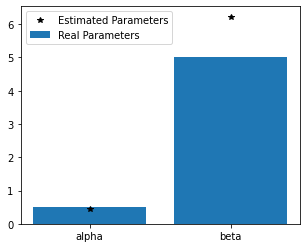

Compare true and fitted values:


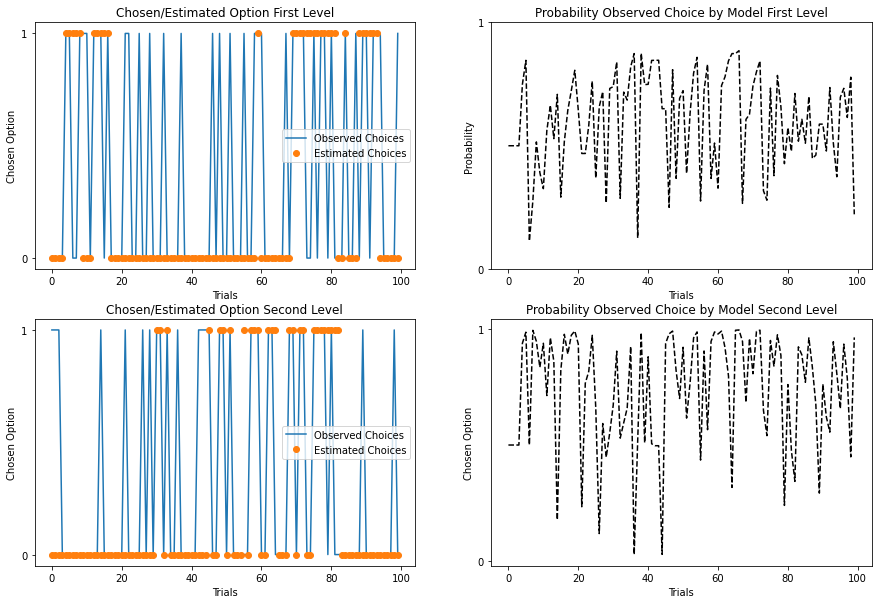

In [24]:
likelihood_func = session_likelihood_MB
param_ranges    = ['unit','pos']
param_names     = ["alpha","beta"]
params          = [0.5, 5]

choices_1, second_steps, choices_2, reward, _ = simulate_MB(n_trials = 100, alpha=params[0], beta=params[1])

session_fit = fit_session(likelihood_func, param_ranges, params, param_names,
                          choices_1, second_steps, choices_2, reward,
                          repeats = 5, brute_init = True, verbose = False)

_, choice_probs_1, choice_probs_2 = session_likelihood_MB(session_fit['params'], choices_1, second_steps, choices_2, reward, fit=False)

plt.rcParams['figure.figsize'] = [5, 4]
plt.bar(np.arange(len(param_names)),params,label="Real Parameters")
plt.plot(session_fit['params'],'*k',label="Estimated Parameters")
plt.xticks(np.arange(len(param_names)),param_names)
plt.legend()
plt.show()

print("Compare true and fitted values:")

plot_fit(choices_1,choices_2,choice_probs_1,choice_probs_2)

In [25]:
# @title Exercise 5.2.1: Model fitting

How well can you recover the true parameters if you simulate model-free/model-based behaviour and try to estimate the parameters using the model-based/model-free agent?

## [Bonus] 5.3 Mixed agent

In [28]:
def session_likelihood_MFMB(params, choice_1=[], second_steps=[], choice_2=[], reward=[], fit=True):

  # Unpack parameters - this is the key idea
  alpha, beta, w = params  

  # Unpack trial events.
  if len(choice_1)==0:
    n_trials   = 100  # Number of trials per session.
    choice_1, second_steps, choice_2, reward, _ = simulate_MF(n_trials)
  else:
    n_trials = len(choice_1)

  # Initiate variables
  Q_mb   = np.zeros(2)      # Model based action values.
  Q_td_1 = np.zeros(2)      # First step action values
  Q_td_2 = np.zeros([2,2])  # Second_step action values, indicies: [state, action]

  Q_mb_array   = np.zeros([n_trials + 1, 2])     # Model based action values.
  Q_td_1_array = np.zeros([n_trials + 1, 2])     # Second step action values for second step reached on each trial.
  Q_td_2_array = np.zeros([n_trials + 1, 2])     # Second step action values for second step reached on each trial.

  # simulate updating of Q-values based on REAL experience
  for i in range(n_trials):

    for j in range(2):
      Q_mb_array[i,j]   = Q_mb[j]
      Q_td_1_array[i,j] = Q_td_1[j]
      Q_td_2_array[i,j] = Q_td_2[second_steps[i],j]

    # update action values.
    Q_td_1[choice_1[i]] = Q_td_1[choice_1[i]] +  alpha * (reward[i] - Q_td_1[choice_1[i]])

    Q_td_2[second_steps[i],choice_2[i]] = Q_td_2[second_steps[i],choice_2[i]] + alpha * (reward[i] - Q_td_2[second_steps[i],choice_2[i]])

    Q_s_0 = np.max(Q_td_2[0,:]) # Max action value in second step state 0.
    Q_s_1 = np.max(Q_td_2[1,:]) # Max action value in second step state 1.

    Q_mb[0] = 0.7 * Q_s_0 + 0.3 * Q_s_1
    Q_mb[1] = 0.3 * Q_s_0 + 0.7 * Q_s_1  

  # Evaluate choice probabilities and likelihood. 
  weighted_Q = w * Q_mb_array + (1-w) * Q_td_1_array

  choice_probs_1 = array_softmax(weighted_Q, beta)
  choice_probs_2 = array_softmax(Q_td_2_array, beta)

  # Unpack parameters - this is the otherkey idea
  trial_log_likelihood_1 = protected_log(choice_probs_1[np.arange(n_trials), choice_1])
  trial_log_likelihood_2 = protected_log(choice_probs_2[np.arange(n_trials), choice_2])
  
  session_log_likelihood = np.sum(trial_log_likelihood_1) + np.sum(trial_log_likelihood_2)
  
  if fit:
    return session_log_likelihood
  else:
    return session_log_likelihood, choice_probs_1, choice_probs_2

Finished simulation 1 of 3.
Finished simulation 2 of 3.
Finished simulation 3 of 3.
{'likelihood': -89.39127692239056, 'param_names': ['alpha', 'beta', 'w'], 'params': array([0.55158031, 5.63979828, 0.54299712])}


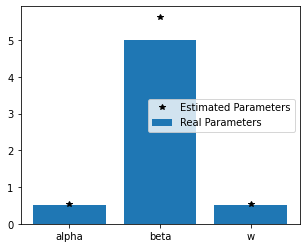

Compare true and fitted values:


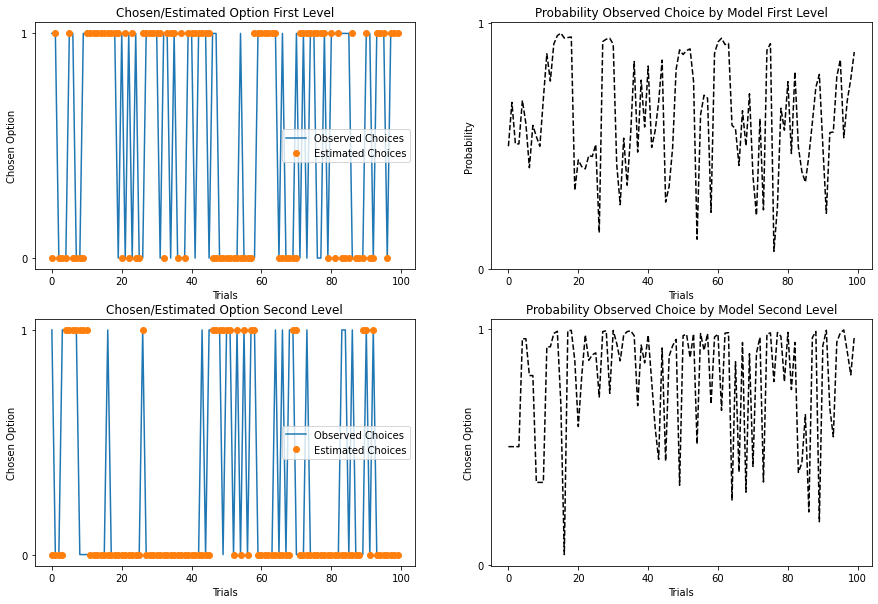

In [29]:
likelihood_func = session_likelihood_MFMB
param_ranges    = ['unit','pos','unit']
param_names     = ["alpha","beta","w"]
params          = [0.5, 5, 0.5]

choices_1, second_steps, choices_2, reward, _ = simulate_MFMB(n_trials = 100, alpha=params[0], beta=params[1], w=params[2])

session_fit = fit_session(likelihood_func, param_ranges, params, param_names,
                          choices_1, second_steps, choices_2, reward,
                          repeats = 3, brute_init = True, verbose = False)

_, choice_probs_1, choice_probs_2 = session_likelihood_MFMB(session_fit['params'], choices_1, second_steps, choices_2, reward, fit=False)

plt.rcParams['figure.figsize'] = [5, 4]
plt.bar(np.arange(len(param_names)),params,label="Real Parameters")
plt.plot(session_fit['params'],'*k',label="Estimated Parameters")
plt.xticks(np.arange(len(param_names)),param_names)
plt.legend()
plt.show()

print("Compare true and fitted values:")

plot_fit(choices_1,choices_2,choice_probs_1,choice_probs_2)

Notice how much longer this takes by just adding one single parameter!